In [1]:

from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Каталог с данными для обучения
train_dir = 'cadmnist2/train'
# Каталог с данными для проверки
val_dir = 'cadmnist2/val'
# Каталог с данными для тестирования
test_dir = 'cadmnist2/test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 1)
# Количество эпох
epochs = 20
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 578
# Количество изображений для проверки
nb_validation_samples = 187
# Количество изображений для тестирования
# nb_test_samples = 86
# количество классов
num_classes=5

In [3]:
model = models.Sequential()

model.add(layers.Conv2D(128, (3, 3), input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     1280      
                                                                 
 activation (Activation)     (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       147584    
                                                                 
 activation_1 (Activation)   (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                    

In [4]:


datagen = ImageDataGenerator(rescale=1. / 255, width_shift_range=5, height_shift_range=5)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=1)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=1)

# test_generator = datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_width, img_height),
#     color_mode='grayscale',
#     batch_size=batch_size,
#     class_mode='categorical')

Found 578 images belonging to 5 classes.
Found 187 images belonging to 5 classes.


In [5]:
# x,y=train_generator.next()
# print(x.shape)
# plt.imshow(x[0])
# print(y[0])

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
36/36 [==============================] - 54s 1s/step - loss: 0.9554 - accuracy: 0.6423 - val_loss: 0.4666 - val_accuracy: 0.8864
Epoch 2/20
36/36 [==============================] - 59s 2s/step - loss: 0.3761 - accuracy: 0.8843 - val_loss: 0.2945 - val_accuracy: 0.9205
Epoch 3/20
36/36 [==============================] - 54s 1s/step - loss: 0.1816 - accuracy: 0.9395 - val_loss: 0.3531 - val_accuracy: 0.9205
Epoch 4/20
36/36 [==============================] - 56s 2s/step - loss: 0.1545 - accuracy: 0.9573 - val_loss: 0.2133 - val_accuracy: 0.9375
Epoch 5/20
36/36 [==============================] - 54s 2s/step - loss: 0.1253 - accuracy: 0.9555 - val_loss: 0.2214 - val_accuracy: 0.9318
Epoch 6/20
36/36 [==============================] - 69s 2s/step - loss: 0.0652 - accuracy: 0.9769 - val_loss: 0.2052 - val_accuracy: 0.9375
Epoch 7/20
36/36 [==============================] - 55s 2s/step - loss: 0.0782 - accuracy: 0.9769 - val_loss: 0.4484 - val_accuracy: 0.9034
Epoch 8/20
36/36 [==

In [8]:
model.save('cadmnist.h5')

In [9]:
def make_square(img, max_size, fill_color):
    # find image dimensions
    old_img = Image.fromarray(img)
    size = (min(max_size, max(old_img.size)),) * 2

    # resize if old image is larger than max_size
    if size[0] < old_img.size[0] or size[1] < old_img.size[1]:
        old_img.thumbnail(size)

    # create new image with the given color and computed size
    new_img = Image.new(old_img.mode, size, fill_color)

    # find coordinates of upper-left corner to center the old image in the new image
    assert new_img.size[0] >= old_img.size[0]
    assert new_img.size[1] >= old_img.size[1]

    x = (new_img.size[0] - old_img.size[0]) // 2
    y = (new_img.size[1] - old_img.size[1]) // 2

    # paste image
    new_img.paste(old_img, (x, y))

    # save image
    if(max(new_img.size)<img_width):
        new_img=new_img.resize((img_width,img_height))
    return np.array(new_img)

def prepare(img):
    ret, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    padded= np.pad(th, ((5, 5), (5, 5)), "constant", constant_values=0)
    squared=make_square(padded, img_height, 0)
    ret, th = cv2.threshold(squared, 0, 255, cv2.THRESH_OTSU)
    return th


1/1 [==============================] - 0s 183ms/step
bearing 100%
1/1 [==============================] - 0s 51ms/step
bolt 100%
1/1 [==============================] - 0s 47ms/step
nut 100%
1/1 [==============================] - 0s 48ms/step
seal 100%
1/1 [==============================] - 0s 50ms/step
washer 100%


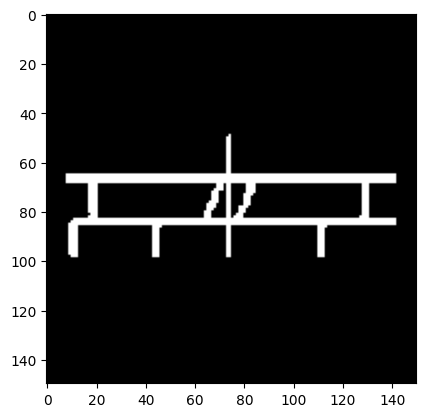

In [10]:
model = models.load_model('cadmnist.h5')
classes=["bearing", "bolt", "nut", "seal", "washer"]

img=cv2.imread(test_dir+'/bearing.jpg', cv2.IMREAD_GRAYSCALE)
img=prepare(img)
img=img.reshape((1,img_width,img_height,1))
pred = model.predict(img)[0]
final_pred = np.argmax(pred)
data = classes[final_pred] + ' ' + str(int(max(pred) * 100)) + '%'
plt.imshow(img.reshape((img_width,img_height)), cmap='gray')
print(data)

img=cv2.imread(test_dir+'/bolt.jpg', cv2.IMREAD_GRAYSCALE)
img=prepare(img)
img=img.reshape((1,img_width,img_height,1))
pred = model.predict(img)[0]
final_pred = np.argmax(pred)
data = classes[final_pred] + ' ' + str(int(max(pred) * 100)) + '%'
plt.imshow(img.reshape((img_width,img_height)), cmap='gray')
print(data)

img=cv2.imread(test_dir+'/nut.jpg', cv2.IMREAD_GRAYSCALE)
img=prepare(img)
img=img.reshape((1,img_width,img_height,1))
pred = model.predict(img)[0]
final_pred = np.argmax(pred)
data = classes[final_pred] + ' ' + str(int(max(pred) * 100)) + '%'
plt.imshow(img.reshape((img_width,img_height)), cmap='gray')
print(data)

img=cv2.imread(test_dir+'/seal.jpg', cv2.IMREAD_GRAYSCALE)
img=prepare(img)
img=img.reshape((1,img_width,img_height,1))
pred = model.predict(img)[0]
final_pred = np.argmax(pred)
data = classes[final_pred] + ' ' + str(int(max(pred) * 100)) + '%'
plt.imshow(img.reshape((img_width,img_height)), cmap='gray')
print(data)

img=cv2.imread(test_dir+'/washer.jpg', cv2.IMREAD_GRAYSCALE)
img=prepare(img)
img=img.reshape((1,img_width,img_height,1))
pred = model.predict(img)[0]
final_pred = np.argmax(pred)
data = classes[final_pred] + ' ' + str(int(max(pred) * 100)) + '%'
plt.imshow(img.reshape((img_width,img_height)), cmap='gray')
print(data)